# **Projet Python pour la Data Science**
### **Modélisation des valeurs du CAC40 à partir des politiques de la BCE**
Notre projet est issu d'une réflexion autour des prédictions du marché des actions. Dans ce projet Python pour la Data Science, nous cherchons à produire un modèle de prédiction des valeurs du CAC40, en fonction des politiques de la Banque Centrale Européenne. 

Notre travail s'est décliné en plusieurs étapes : 

- Définir nos variables explicatives, les importer 
- Nettoyer ces données pour les rendre exploitables
- Trouver le modèle pertinent pour expliquer l'influence des variables sur les valeurs du CAC40

### **Sommaire**
1. Installation 
2. Récupération des données 
3. Nettoyage des données
4. Analyse descriptive
5. Premières modélisations : Expression du CAC 40 en fonction des variables macroéconomiques
6. Modélisation : Prédiction des variations du CAC 40 à partir des politiques monétaires
    

### **Installation**


In [62]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

!pip install --upgrade scikit-learn
!pip install openpyxl
!pip install yfinance
import yfinance as yf

SyntaxError: invalid syntax (248339071.py, line 7)

##### **Chargement des fichiers Excel qui forment la base de donnée**

In [2]:
chomage = pd.read_excel('Chômage_depuis1975.xlsx')
confiance = pd.read_excel('Confiance_ménages.xlsx')
ev_pib = pd.read_excel('Evolution_PIB_trimestre.xlsx')
ipc = pd.read_excel('ipc_menages.xlsx')

/opt/conda/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


##### **Nettoyage des données**

In [3]:
chomage.head()

,Tableau 1. Taux de chômage trimestriel au sens du BIT en France (hors Mayotte) par sexe et âge,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,"Données CVS en moyenne trimestrielle, en %",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,En jaune : Les séries ont été constituées à pa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,HOMMES (%),NaN,NaN,NaN,FEMMES (%),NaN,NaN,NaN,TOTAL (%),NaN,NaN,NaN,Nombre de chômeurs
4,trimestre.année,Âge,NaN,NaN,Total,Âge,NaN,NaN,Total,Âge,NaN,NaN,Total,NaN


In [4]:
print(chomage)

    Tableau 1. Taux de chômage trimestriel au sens du BIT en France (hors Mayotte) par sexe et âge  \
0           Données CVS en moyenne trimestrielle, en %                                               
1                                                  NaN                                               
2    En jaune : Les séries ont été constituées à pa...                                               
3                                                  NaN                                               
4                                      trimestre.année                                               
..                                                 ...                                               
203                                            T2.2024                                               
204                                            T3.2024                                               
205                                                NaN                            

In [5]:
# Renommer les colonnes à utiliser
chomage.rename(columns={'Unnamed: 12': 'taux_chomage'}, inplace=True)
chomage.rename(columns={'Tableau 1. Taux de chômage trimestriel au sens du BIT en France (hors Mayotte) par sexe et âge': 'trimestre'}, inplace=True) 

In [6]:
print(chomage.columns)

Index(['trimestre', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'taux_chomage', 'Unnamed: 13'],
      dtype='object')


In [7]:
# Supprimer les colonnes inutiles
chomage.drop(columns=[ 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 
    'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 
    'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 13'], inplace=True)

# Afficher la table après suppression
chomage

,trimestre,taux_chomage
0,"Données CVS en moyenne trimestrielle, en %",NaN
1,NaN,NaN
2,En jaune : Les séries ont été constituées à pa...,NaN
3,NaN,NaN
4,trimestre.année,Total
...,...,...
203,T2.2024,7.3
204,T3.2024,7.4
205,NaN,NaN
206,"Champ : France hors Mayotte, personnes vivant ...",NaN


In [8]:
# Trouver l'index de la valeur 'T1.2000' dans la colonne 'trimestre'
index_t1_2000 = chomage[chomage['trimestre'] == 'T1.2000'].index

# Afficher l'index
print(index_t1_2000)


Index([106], dtype='int64')


In [9]:
# On supprime les premières lignes inutiles pour que les données débutent au premier trimestre  
chomage = chomage.iloc[106:].reset_index(drop=True)

# Afficher les premieres lignes des données nettoyées
chomage.head()


,trimestre,taux_chomage
0,T1.2000,9.1
1,T2.2000,8.7
2,T3.2000,8.4
3,T4.2000,8
4,T1.2001,7.8


In [10]:
print(chomage.trimestre)

0                                                T1.2000
1                                                T2.2000
2                                                T3.2000
3                                                T4.2000
4                                                T1.2001
                             ...                        
97                                               T2.2024
98                                               T3.2024
99                                                   NaN
100    Champ : France hors Mayotte, personnes vivant ...
101                       Source : Insee, enquête Emploi
Name: trimestre, Length: 102, dtype: object


In [11]:
#Déterminuer où sont situés les NaN s'il y en a
print(chomage[chomage.isna().any(axis=1)])

                                             trimestre taux_chomage
99                                                 NaN          NaN
100  Champ : France hors Mayotte, personnes vivant ...          NaN
101                     Source : Insee, enquête Emploi          NaN


In [12]:
# Supprimer les lignes contenant des NaN car elles ne comportent pas de données
chomage = chomage.dropna()

# Vérifier le résultat
print(chomage.isna().sum())  

trimestre       0
taux_chomage    0
dtype: int64


Nettoyage des données sur la confiance 

In [13]:
confiance.head()

,Opinion des ménages-Monthly confidence consumer survey,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,Données corrigées des variations saisonnières-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DATE,Indicateur synthétique,Niveau de vie en France - évolution passée,Niveau de vie en France - perspectives d'évolu...,Chômage - perspectives d'évolution,Prix - évolution passée,Prix - perspectives d'évolution,Opportunité de faire des achats importants,Opportunité d'épargner,Capacité d'épargne actuelle,Situation financière personnelle - évolution p...,Situation financière personnelle - perspective...,Capacité d'épargne future
3,NaN,Synthetic index,"General economic situation, past 12 months","General economic situation, next 12 months","Unemployment, next 12 months","Consumer prices, past 12 months","Consumer prices, next 12 months","Major purchases intentions, next 12 months","Savings intentions, next 12 months",Current saving capacity,"Financial situation, past 12 months","Financial situation, next 12 months",Expected saving capacity
4,moyenne/average,100,-47.749835,-27.733798,32.585969,-13.383858,-31.095762,-15.188091,18.029779,9.656539,-20.980754,-6.560103,-7.110802


In [14]:
# Renommer les colonnes à utiliser
confiance.rename(columns={'Unnamed: 1': 'indic_confiance'}, inplace=True)
confiance.rename(columns={'Opinion des ménages-Monthly confidence consumer survey': 'date'}, inplace=True) 

In [15]:
print(confiance.columns)

Index(['date', 'indic_confiance', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')


In [16]:
# Supprimer les colonnes inutiles pour notre analyse
confiance.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], inplace=True)

In [17]:
# S'assurer que la colonne 'date' est au format datetime
confiance['date'] = pd.to_datetime(confiance['date'], errors='coerce')

# Filtrer les données à partir de janvier 2000
confiance =confiance[confiance['date'] >= '2000-01-01']

# Afficher les premières lignes des données filtrées
confiance.head()

/tmp/ipykernel_24338/3570054967.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  confiance['date'] = pd.to_datetime(confiance['date'], errors='coerce')


,date,indic_confiance
204,2000-01-01,119.186742
205,2000-02-01,119.010085
206,2000-03-01,119.930046
207,2000-04-01,122.586881
208,2000-05-01,122.625812


In [ ]:
# Convertir les données journalières en trimestrielles (moyenne trimestrielle)
confiance["date"] = pd.to_datetime(confiance["date"])
confiance.set_index("date", inplace=True)
confiance = confiance.resample("QE").mean()

#Réinitialisation de la colonne date et changement de nom
confiance = confiance.reset_index()
confiance.rename(columns={'date': 'trimestre'}, inplace=True) 

#Vérification
confiance.head()

,trimestre,indic_confiance
0,2000-03-31,119.375624
1,2000-06-30,122.715558
2,2000-09-30,121.334655
3,2000-12-31,121.035423
4,2001-03-31,124.096635


In [19]:
print(confiance.trimestre)

0    2000-03-31
1    2000-06-30
2    2000-09-30
3    2000-12-31
4    2001-03-31
        ...    
95   2023-12-31
96   2024-03-31
97   2024-06-30
98   2024-09-30
99   2024-12-31
Name: trimestre, Length: 100, dtype: datetime64[ns]


In [20]:
#Transformation de l'écriture des éléments de la colonne trimestre pour que toutes les colonnes soient du même format
# On sait que la colonne des dates est bien en format datetime

def format_trimestre(trimestre):
    # Extraire l'année et le trimestre
    annee = trimestre.year
    mois = trimestre.month
    # Calculer le trimestre en fonction du mois
    if mois in [3]:
        trimestre = "T1"
    elif mois in [6]:
        trimestre = "T2"
    elif mois in [9]:
        trimestre = "T3"
    else:
        trimestre = "T4"
    # Retourner le format "T1.2000"
    return f"{trimestre}.{annee}"

# Appliquer la fonction à chaque date pour créer la nouvelle colonne
confiance['trimestre'] = confiance['trimestre'].apply(format_trimestre)

confiance.head()


,trimestre,indic_confiance
0,T1.2000,119.375624
1,T2.2000,122.715558
2,T3.2000,121.334655
3,T4.2000,121.035423
4,T1.2001,124.096635


In [21]:
#Déterminuer où sont situés les NaN s'il y en a
print(confiance[confiance.isna().any(axis=1)])

Empty DataFrame
Columns: [trimestre, indic_confiance]
Index: []


Nettoyage de la table Evolution du PIB

On cherche à isoler des indicateurs pour l'évolution du PIB, la consommation des ménages et des APU, la formation brute de capital fixe, les importations et exportations. On fait le choix de prendre plus d'indicateurs, quitte à les éliminer par la suite.

In [22]:
ev_pib.head()

,Évolution du produit intérieur brut et de ses composantes,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,par rapport au trimestre précédent en volume en %,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Trimestre,Produit intérieur brut (PIB),Importations,Dépense de consommation des ménages,Dépense de consommation des APU1,Formation brute de capital fixe,dont :,NaN,NaN,Exportations,Contributions :,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,Entreprises non financières,ménages,APU1,NaN,Demande intérieure finale hors stocks,Variations de stocks,Commerce extérieur
4,2024-T3,0.362294,-0.684306,0.515766,0.513113,-0.84265,-1.365417,-0.887841,0.472325,-0.470732,0.212544,0.069318,0.080432


In [23]:
# Renommer les colonnes à utiliser
ev_pib.rename(columns={'Évolution du produit intérieur brut et de ses composantes': 'trimestre'}, inplace=True)
ev_pib.rename(columns={'Unnamed: 1': 'ev_pib'}, inplace=True) 
ev_pib.rename(columns={'Unnamed: 2': 'ev_importations'}, inplace=True) 
ev_pib.rename(columns={'Unnamed: 3': 'ev_conso_menages'}, inplace=True) 
ev_pib.rename(columns={'Unnamed: 4': 'ev_conso_apu'}, inplace=True) 
ev_pib.rename(columns={'Unnamed: 5': 'ev_fbcf'}, inplace=True) 
ev_pib.rename(columns={'Unnamed: 9': 'ev_exportations'}, inplace=True) 

In [24]:
print(ev_pib.columns)

Index(['trimestre', 'ev_pib', 'ev_importations', 'ev_conso_menages',
       'ev_conso_apu', 'ev_fbcf', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
       'ev_exportations', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'],
      dtype='object')


In [25]:
# Supprimer les colonnes
ev_pib.drop(columns=['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8',
    'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], inplace=True)

#Inversion des colonnes pour avoir des données chronologiques
ev_pib = ev_pib.iloc[::-1].reset_index(drop=True)

# Vérification
ev_pib.head()

,trimestre,ev_pib,ev_importations,ev_conso_menages,ev_conso_apu,ev_fbcf,ev_exportations
0,"Source : Insee, comptes nationaux trimestriels...",NaN,NaN,NaN,NaN,NaN,NaN
1,Champ : France.,NaN,NaN,NaN,NaN,NaN,NaN
2,"Lecture : au 3e trimestre 2024, le produit int...",NaN,NaN,NaN,NaN,NaN,NaN
3,Note : données révisées ; les volumes sont mes...,NaN,NaN,NaN,NaN,NaN,NaN
4,1. Administrations publiques.,NaN,NaN,NaN,NaN,NaN,NaN


On remarque que les données sont ordonnées des plus récentes aux plus anciennes, on souhaite inverser cela pour faciliter le travail avec les autres tables. 

In [26]:
# Trouver l'index de la valeur '2000-T1' dans la colonne 'trimestre'
index_2000_t1 = ev_pib[ev_pib['trimestre'] == '2000-T1'].index

# Afficher l'index
print(index_2000_t1)


Index([209], dtype='int64')


In [27]:
# On supprime les premières lignes inutiles pour que les données débutent au premier trimestre de l'année 2000
ev_pib = ev_pib.iloc[209:].reset_index(drop=True)

On souhaite créer une nouvelle variable qui regroupe l'évolution de la consommation des ménages et des APU.

In [28]:
ev_pib['ev_conso'] = ev_pib['ev_conso_menages'] + ev_pib['ev_conso_apu']

# Afficher les premieres lignes des données 
ev_pib.head()

,trimestre,ev_pib,ev_importations,ev_conso_menages,ev_conso_apu,ev_fbcf,ev_exportations,ev_conso
0,2000-T1,1.011252,4.716928,1.256031,0.606497,2.244349,2.839274,1.862528
1,2000-T2,1.06425,4.20051,0.772804,0.464126,0.921508,4.963057,1.23693
2,2000-T3,0.780148,3.529602,0.444674,0.34475,2.53796,1.41363,0.789424
3,2000-T4,0.563163,2.2326,0.132284,0.155773,0.073162,2.984615,0.288057
4,2001-T1,0.57489,-1.295035,1.139891,0.125288,0.672418,0.408129,1.265179


In [29]:
print(ev_pib.trimestre)

0                                                2000-T1
1                                                2000-T2
2                                                2000-T3
3                                                2000-T4
4                                                2001-T1
                             ...                        
98                                               2024-T3
99                                                   NaN
100                                            Trimestre
101    par rapport au trimestre précédent en volume en %
102                                                  NaN
Name: trimestre, Length: 103, dtype: object


In [30]:
#Transformation de l'écriture des éléments de la colonne trimestre pour que toutes les colonnes soient du même format
# On vérifie que la colonne des trimestres est en chaîne de caractères
ev_pib['trimestre'] = ev_pib['trimestre'].astype(str)  

# Fonction pour convertir le format '2000-T1' en 'T1.2000'
def convertir_format(trimestre):
    try:
        # On vérifie si le format est correct (années-trimestre)
        annee, trimestre_num = trimestre.split('-')
        return f"{trimestre_num}.{annee}"  # On recompose le format 'T1.2000'
    except ValueError:
        # Pour les cas où le format n'est pas correct on ne change rien, c'est des valeurs inutiles qu'on supprimera ensuite.
        return trimestre  
   

# On applique la fonction à chaque valeur de la colonne
ev_pib['trimestre'] = ev_pib['trimestre'].apply(convertir_format)

#Verification
ev_pib.head()


,trimestre,ev_pib,ev_importations,ev_conso_menages,ev_conso_apu,ev_fbcf,ev_exportations,ev_conso
0,T1.2000,1.011252,4.716928,1.256031,0.606497,2.244349,2.839274,1.862528
1,T2.2000,1.06425,4.20051,0.772804,0.464126,0.921508,4.963057,1.23693
2,T3.2000,0.780148,3.529602,0.444674,0.34475,2.53796,1.41363,0.789424
3,T4.2000,0.563163,2.2326,0.132284,0.155773,0.073162,2.984615,0.288057
4,T1.2001,0.57489,-1.295035,1.139891,0.125288,0.672418,0.408129,1.265179


Vérification des NaN

In [31]:
print(ev_pib[ev_pib.isna().any(axis=1)])

                                             trimestre ev_pib ev_importations  \
99                                                 nan    NaN             NaN   
101  par rapport au trimestre précédent en volume en %    NaN             NaN   
102                                                nan    NaN             NaN   

    ev_conso_menages ev_conso_apu ev_fbcf ev_exportations ev_conso  
99               NaN          NaN     NaN             NaN      NaN  
101              NaN          NaN     NaN             NaN      NaN  
102              NaN          NaN     NaN             NaN      NaN  


In [32]:
#Suppression des lignes avec des NaN car elles ne nous intéressent pas
ev_pib = ev_pib.dropna()

#Vérification
print(ev_pib.isna().sum())

trimestre           0
ev_pib              0
ev_importations     0
ev_conso_menages    0
ev_conso_apu        0
ev_fbcf             0
ev_exportations     0
ev_conso            0
dtype: int64


Nettoyage des données sur l'indice des prix à la consommation

In [33]:
ipc.head()

,Libellé,Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble,Unnamed: 2
0,idBank,001759970,NaN
1,Dernière mise à jour,29/11/2024 08:45,NaN
2,Période,NaN,Date de parution au JO
3,2024-11,119.81,NaN
4,2024-10,119.89,17/11/2024


In [34]:
# Renommer les colonnes à utiliser
ipc.rename(columns={'Libellé': 'mois_année'}, inplace=True)
ipc.rename(columns={'Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble': 'ipc_menage'}, inplace=True) 

In [35]:
print(ipc.columns)

Index(['mois_année', 'ipc_menage', 'Unnamed: 2'], dtype='object')


In [36]:
# Supprimer les colonnes
ipc.drop(columns='Unnamed: 2', inplace=True)

# On supprime les premières lignes inutiles 
ipc = ipc.iloc[3:].reset_index(drop=True)

#Inversion des données pour les classer en ordre chronologique
ipc = ipc.iloc[::-1].reset_index(drop=True)

# Trouver l'index de la valeur '2000-01' dans la colonne 'mois_année'
index_2000_01 = ipc[ipc['mois_année'] == '2000-01'].index

# Afficher l'index
print(index_2000_01)

Index([120], dtype='int64')


In [37]:
# On supprime les premières lignes pour que les données débutent en janvier 2000
ipc = ipc.iloc[120:].reset_index(drop=True)

ipc.head()

,mois_année,ipc_menage
0,2000-01,79.17
1,2000-02,79.27
2,2000-03,79.64
3,2000-04,79.64
4,2000-05,79.8


In [38]:
#Vérification des NaN
print(ipc[ipc.isna().any(axis=1)])

Empty DataFrame
Columns: [mois_année, ipc_menage]
Index: []


In [39]:
#Passage de données mensuelles à trimestrielles
# Conversion de la colonne 'mois_année' en type datetime
ipc['mois_année'] = pd.to_datetime(ipc['mois_année'], format='%Y-%m')

# Définir la colonne 'mois_année' comme index
ipc.set_index('mois_année', inplace=True)

# Résumer les données par trimestre (somme dans cet exemple)
ipc = ipc.resample('QE').sum()

#Réinitialisation de la colonne mois_année et changement de nom
ipc = ipc.reset_index()
ipc.rename(columns={'mois_année': 'trimestre'}, inplace=True) 

#Vérification 
ipc.head()

,trimestre,ipc_menage
0,2000-03-31,238.08
1,2000-06-30,239.44
2,2000-09-30,240.32
3,2000-12-31,241.31
4,2001-03-31,241.19


In [40]:
#On utilise la fonction définie précedemmentpour modifier la colonne trimestre pour que toutes les colonnes soient du même format
ipc['trimestre'] = ipc['trimestre'].apply(format_trimestre)

#Verification
ipc.head()

,trimestre,ipc_menage
0,T1.2000,238.08
1,T2.2000,239.44
2,T3.2000,240.32
3,T4.2000,241.31
4,T1.2001,241.19


Téléchargement des données sur le CAC 40

In [ ]:
# Téléchargement les données trimestrielles du CAC 40 avec l'API yfinance
CAC40_y = "^FCHI"  # Symbole Yahoo Finance pour le CAC 40
dfcac40 = yf.download(CAC40_y, start="2000-01-01", interval="3mo")

# Sauvegarder en CSV 
dfcac40.to_csv("cac40_trimestre.csv")


[*********************100%***********************]  1 of 1 completed


nettoyage des données du CAC40

In [43]:
cac40 = pd.read_csv("cac40_trimestre.csv")

In [44]:
cac40.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,^FCHI,^FCHI,^FCHI,^FCHI,^FCHI
1,Date,NaN,NaN,NaN,NaN,NaN
2,1999-12-01,6190.9599609375,6396.97021484375,5388.85009765625,6024.3798828125,0
3,2000-03-01,6426.259765625,6591.43994140625,5752.43994140625,6272.1298828125,0
4,2000-06-01,6625.419921875,6780.66015625,6354.93017578125,6428.4599609375,0


In [45]:
# Supprimer la colonne Volume
cac40.drop(columns='Volume', inplace=True)

#Supprimer les deux premières colonnes inutiles
cac40 = cac40.iloc[3:].reset_index(drop=True)

# Afficher les premières lignes du après suppression
cac40.head()

,Price,Close,High,Low,Open
0,2000-03-01,6426.259765625,6591.43994140625,5752.43994140625,6272.1298828125
1,2000-06-01,6625.419921875,6780.66015625,6354.93017578125,6428.4599609375
2,2000-09-01,5928.080078125,6944.77001953125,5828.14013671875,6648.64013671875
3,2000-12-01,5367.47998046875,6126.41015625,5302.7900390625,5942.35986328125
4,2001-03-01,5454.18994140625,5728.52001953125,4804.39990234375,5334.22998046875


In [46]:
#Changement de nom de la colonne Price en date
cac40.rename(columns={'Price': 'trimestre'}, inplace=True)

In [47]:
#Vérification des NaN 
print(cac40[cac40.isna().any(axis=1)])

Empty DataFrame
Columns: [trimestre, Close, High, Low, Open]
Index: []


In [48]:
#On vérifie que les données de la colonne trimestre soient du format datetime
cac40['trimestre'] = pd.to_datetime(cac40['trimestre']) 

#On utilise la fonction définie précedemmentpour modifier la colonne trimestre pour que toutes les colonnes soient du même format
cac40['trimestre'] = cac40['trimestre'].apply(format_trimestre)

#Verification
cac40.head()

,trimestre,Close,High,Low,Open
0,T1.2000,6426.259765625,6591.43994140625,5752.43994140625,6272.1298828125
1,T2.2000,6625.419921875,6780.66015625,6354.93017578125,6428.4599609375
2,T3.2000,5928.080078125,6944.77001953125,5828.14013671875,6648.64013671875
3,T4.2000,5367.47998046875,6126.41015625,5302.7900390625,5942.35986328125
4,T1.2001,5454.18994140625,5728.52001953125,4804.39990234375,5334.22998046875


On veut à présent rassembler toutes les données dans un seul tableau excel indexé par la date en trimestre depuis 2000.

In [49]:
# Fusionner toutes les données dans un seul DataFrame
df = cac40.merge(chomage, on="trimestre").merge(confiance, on="trimestre", how="outer")
df = df.merge(ev_pib, on="trimestre").merge(ipc, on="trimestre")

In [50]:
df.head()

,trimestre,Close,High,Low,Open,taux_chomage,indic_confiance,ev_pib,ev_importations,ev_conso_menages,ev_conso_apu,ev_fbcf,ev_exportations,ev_conso,ipc_menage
0,T1.2000,6426.259765625,6591.43994140625,5752.43994140625,6272.1298828125,9.1,119.375624,1.011252,4.716928,1.256031,0.606497,2.244349,2.839274,1.862528,238.08
1,T1.2001,5454.18994140625,5728.52001953125,4804.39990234375,5334.22998046875,7.8,124.096635,0.57489,-1.295035,1.139891,0.125288,0.672418,0.408129,1.265179,241.19
2,T1.2002,4274.64013671875,4696.18017578125,4239.72021484375,4442.39990234375,7.8,111.588134,0.576628,2.603009,0.127005,0.1896,-1.582585,2.454192,0.316605,246.38
3,T1.2003,2991.75,3070.6201171875,2401.14990234375,2770.679931640625,8.4,101.963384,0.296491,-0.829944,0.471118,0.274707,0.089733,-1.710841,0.745825,252.21
4,T1.2004,3669.6298828125,3831.5400390625,3489.530029296875,3735.300048828125,9,100.722297,1.067723,1.168604,0.624298,0.470123,0.742294,1.236199,1.094421,256.75


Regression linéaire : prédiction du cac 40 à partir d'indicateurs macroéconomiques

Première tentative de regression linéaire 

Sélection des variables dépendantes et indépendantes :

In [53]:
# Variables indépendantes : toutes les colonnes sauf les valeurs du CAC40 ( 'ev_conso_menages','ev_conso_apu')
X = df[['taux_chomage', 'indic_confiance', 'ev_pib', 'ev_importations', 
         'ev_fbcf', 'ev_exportations', 'ev_conso', 'ipc_menage']]

# Variables dépendantes (on cherche celle qui est la plus pertinente)
y = df['Close']  # ou  'High', 'Low', 'Open' selon

In [54]:
# On sépare les données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
# Créer et entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

#Coefficients du model
print("Coefficient :", model.coef_)
print("Interception :", model.intercept_)



Coefficient : [-331.19489787   66.01616187  533.46192953   83.52623971  -77.20988072
  -43.56922056 -221.5544168    37.19602743]
Interception : -9442.76974756196


In [56]:
# Prédictions
y_pred = model.predict(X_test)

# Calcul des métriques
r2 = r2_score(y_test, y_pred)  # R² classique
n = X_test.shape[0]           # Nombre d'observations dans l'ensemble de test
p = X_test.shape[1]           # Nombre de variables explicatives

# Calcul du R² ajusté
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Résultats
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2}")
print(f"R² ajusté: {r2_adjusted}")


RMSE: 486552.0386966692
R²: 0.6729362181799243
R² ajusté: 0.43507164958350575


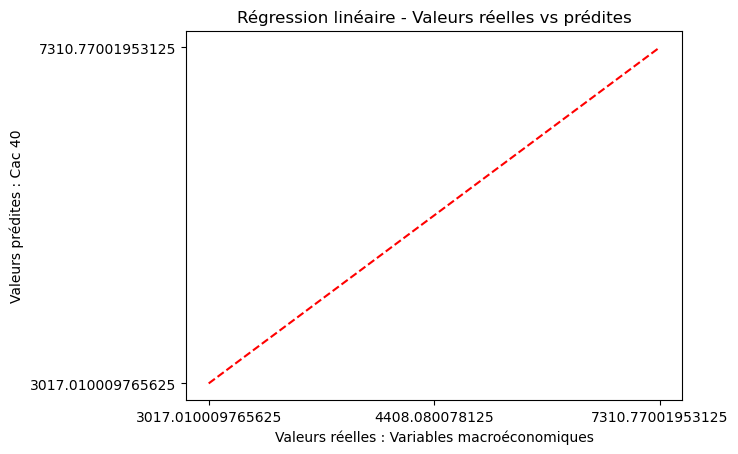

In [ ]:


# Affichage des valeurs réelles vs prédites
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles : Variables macroéconomiques')
plt.ylabel('Valeurs prédites : Cac 40')
plt.title('Régression linéaire - Valeurs réelles vs prédites')
plt.show()


Regression LASSO 

La regression linéaire simple n'a pas donné de résultats satifaisants. On utilise une regression lasso pour éliminer automatiquement les paramètres qui ne sont pas pertinents pour prédire le cac40.

In [58]:


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression Lasso avec un paramètre alpha (régularisation)
alpha = 0.1  #Ce paramètre conrole la pénalisation
lasso = Lasso(alpha=alpha, random_state=42)
lasso.fit(X_train, y_train)

# Prédictions
y_pred = lasso.predict(X_test)

# Calcul des métriques
r2 = r2_score(y_test, y_pred)  # R² classique
n = X_test.shape[0]           # Nombre d'observations
p = X_test.shape[1]           # Nombre de variables explicatives

# Calcul du R² ajusté
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Affichage des résultats
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2}")
print(f"R² ajusté: {r2_adjusted}")

# Affichage des coefficients Lasso
lasso_coefficients = pd.DataFrame({
    "Variable": X.columns,
    "Coefficient": lasso.coef_
})
print(lasso_coefficients[lasso_coefficients["Coefficient"] != 0])  # Variables sélectionnées


RMSE: 486378.7277061798
R²: 0.6730527190749411
R² ajusté: 0.435272878402171
          Variable  Coefficient
0     taux_chomage  -331.138872
1  indic_confiance    66.016722
2           ev_pib   530.118493
3  ev_importations    83.256635
4          ev_fbcf   -76.520324
5  ev_exportations   -42.885342
6         ev_conso  -220.538136
7       ipc_menage    37.198267


On cherche la valeur alpha optimale (validation croisée) :

In [ ]:

# Définir une grille de valeurs pour alpha
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_cv = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

# Meilleur alpha et R²
best_alpha = lasso_cv.best_params_['alpha']
print(f"Meilleur alpha : {best_alpha}")
print(f"Meilleur R² en validation croisée : {lasso_cv.best_score_}")

# Réentraîner avec le meilleur alpha
lasso = Lasso(alpha=best_alpha, random_state=42)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)


Meilleur alpha : 100
Meilleur R² en validation croisée : 0.45410892662079994


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.520e+06, tolerance: 9.368e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.500e+05, tolerance: 9.799e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+06, tolerance: 9.951e

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e+05, tolerance: 1.099e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+05, tolerance: 9.368e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.011e+05, tolerance: 9.799e

Meilleur alpha pour Lasso : 10
Meilleur R² en validation croisée : 0.963486952516814
Lasso - RMSE: 47556.12574805741
Lasso - R²: 0.9680324300407105
Lasso - R² ajusté: 0.8987693617955832
Variables sélectionnées par Lasso :
            Variable  Coefficient
0               High   507.688370
1                Low   676.103773
3       taux_chomage     0.969182
7   ev_conso_menages    34.762357
12        ipc_menage    49.234701
ElasticNet - RMSE: 592866.6652179526
ElasticNet - R²: 0.6014707611529987
ElasticNet - R² ajusté: -0.2620092563488374

Comparaison des performances :
Lasso: R² = 0.9680324300407105, R² ajusté = 0.8987693617955832, RMSE = 47556.12574805741
ElasticNet: R² = 0.6014707611529987, R² ajusté = -0.2620092563488374, RMSE = 592866.6652179526


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e+05, tolerance: 1.003e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e+05, tolerance: 9.368e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+05, tolerance: 9.951e

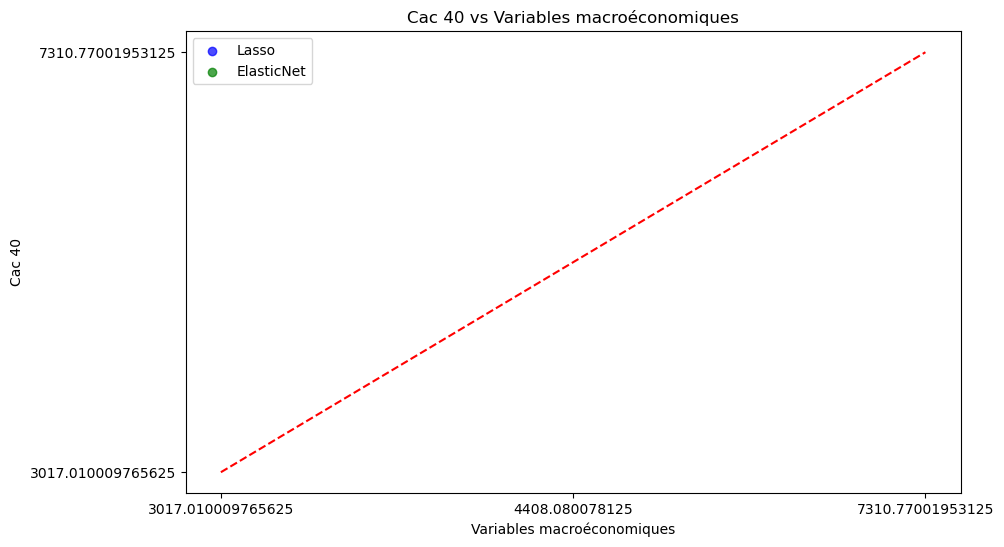

In [ ]:

X = df.drop(columns=["Close", "trimestre"])
y = df["Close"]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Recherche de l'alpha optimal pour Lasso avec validation croisée
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 200]}
lasso_cv = GridSearchCV(Lasso(max_iter=5000, random_state=42), param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

# Meilleur alpha
best_alpha = lasso_cv.best_params_['alpha']
print(f"Meilleur alpha pour Lasso : {best_alpha}")
print(f"Meilleur R² en validation croisée : {lasso_cv.best_score_}")

# Entraînement du modèle Lasso avec le meilleur alpha
lasso = Lasso(alpha=best_alpha, max_iter=5000, random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Calcul des métriques pour Lasso
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso)
n, p = X_test.shape
r2_adjusted_lasso = 1 - ((1 - r2_lasso) * (n - 1) / (n - p - 1))

print(f"Lasso - RMSE: {rmse_lasso}")
print(f"Lasso - R²: {r2_lasso}")
print(f"Lasso - R² ajusté: {r2_adjusted_lasso}")

# Affichage des coefficients Lasso
# Affichage des coefficients Lasso
lasso_coefficients = pd.DataFrame({
    "Variable": X.columns,  # Utiliser les colonnes de X
    "Coefficient": lasso.coef_
})

print("Variables sélectionnées par Lasso :")
print(lasso_coefficients[lasso_coefficients["Coefficient"] != 0])  # Affiche uniquement les variables sélectionnées


# Tester ElasticNet en cas de convergence difficile pour Lasso
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=0.5, max_iter=5000, random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_enet = elastic_net.predict(X_test)

# Calcul des métriques pour ElasticNet
r2_enet = r2_score(y_test, y_pred_enet)
rmse_enet = mean_squared_error(y_test, y_pred_enet)
r2_adjusted_enet = 1 - ((1 - r2_enet) * (n - 1) / (n - p - 1))

print(f"ElasticNet - RMSE: {rmse_enet}")
print(f"ElasticNet - R²: {r2_enet}")
print(f"ElasticNet - R² ajusté: {r2_adjusted_enet}")

# Comparaison des modèles
print("\nComparaison des performances :")
print(f"Lasso: R² = {r2_lasso}, R² ajusté = {r2_adjusted_lasso}, RMSE = {rmse_lasso}")
print(f"ElasticNet: R² = {r2_enet}, R² ajusté = {r2_adjusted_enet}, RMSE = {rmse_enet}")

# Visualisation des prédictions (facultatif)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.7, label="Lasso", color='blue')
plt.scatter(y_test, y_pred_enet, alpha=0.7, label="ElasticNet", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Variables macroéconomiques')
plt.ylabel('Cac 40')
plt.title('Cac 40 vs Variables macroéconomiques')
plt.legend()
plt.show()


L'absence de points bleu ou vert nous montrent que les regressions ne prédisent pas bien le cac40 à partir des variables macroéconomiques. Nous allons à présent tester une série temporelle. 